## Image-Sweep

In [232]:
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import pandas as pd

import time
import PIL.Image as Image
from IPython.display import Image, display
import matplotlib.cm as cm
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import tensorflowjs as tfjs

# Data Augmentation

In [233]:
with tf.device('/cpu:0'):
    data_augmentation = tf.keras.Sequential([
      tf.keras.layers.RandomFlip('horizontal_and_vertical'),
      tf.keras.layers.RandomRotation(0.2),
      tf.keras.layers.RandomZoom(0.1),
    ])

In [234]:
directory = "data/"

BATCH_SIZE = 16
IMG_SIZE = (192, 192)

train_dataset = tf.keras.utils.image_dataset_from_directory(directory,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            shuffle=True,
                                                            seed=1,
                                                            validation_split=0.20,
                                                            subset = "training")

validation_dataset = tf.keras.utils.image_dataset_from_directory(directory,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            shuffle=True,
                                                            seed=1,
                                                            validation_split=0.20,
                                                            subset = "validation")

Found 826 files belonging to 2 classes.
Using 661 files for training.
Found 826 files belonging to 2 classes.
Using 165 files for validation.


2024-06-05 16:07:39.053463: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


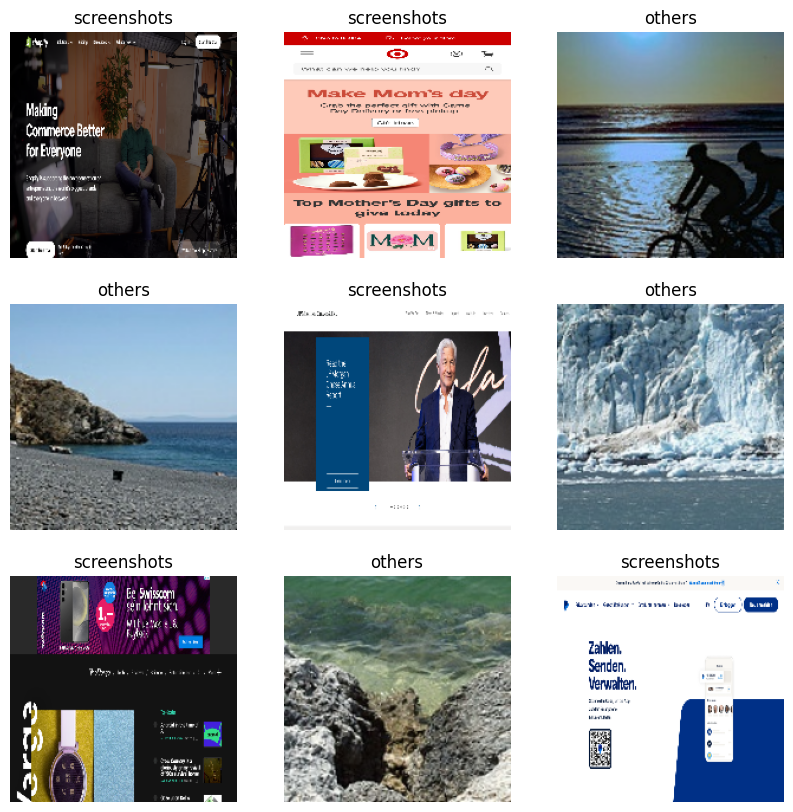

In [235]:
class_names = train_dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [236]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 9
Number of test batches: 2


In [237]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [238]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [239]:
IMG_SHAPE = IMG_SIZE + (3,)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [240]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

2024-06-05 16:07:39.717248: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


(16, 6, 6, 1280)


In [241]:
base_model.trainable = False

In [242]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.Model(inputs, outputs)

In [243]:
base_learning_rate = 0.0001

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [244]:
model.summary()

Model: "functional_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_34 (InputLayer)     │ (None, 192, 192, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_11 (Sequential)      │ (None, 192, 192, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_192            │ (None, 6, 6, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_11     │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [245]:
initial_epochs = 50

loss0, accuracy0 = model.evaluate(validation_dataset)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.4166 - loss: 1.2321
initial loss: 1.27
initial accuracy: 0.39


In [246]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step - accuracy: 0.4548 - loss: 0.9700 - val_accuracy: 0.5639 - val_loss: 0.6348
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.6001 - loss: 0.6808 - val_accuracy: 0.7669 - val_loss: 0.4806
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.6706 - loss: 0.6070 - val_accuracy: 0.8421 - val_loss: 0.4318
Epoch 4/50
31/42 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.6965 - loss: 0.6027

In [ ]:
model.save('models/model.keras')

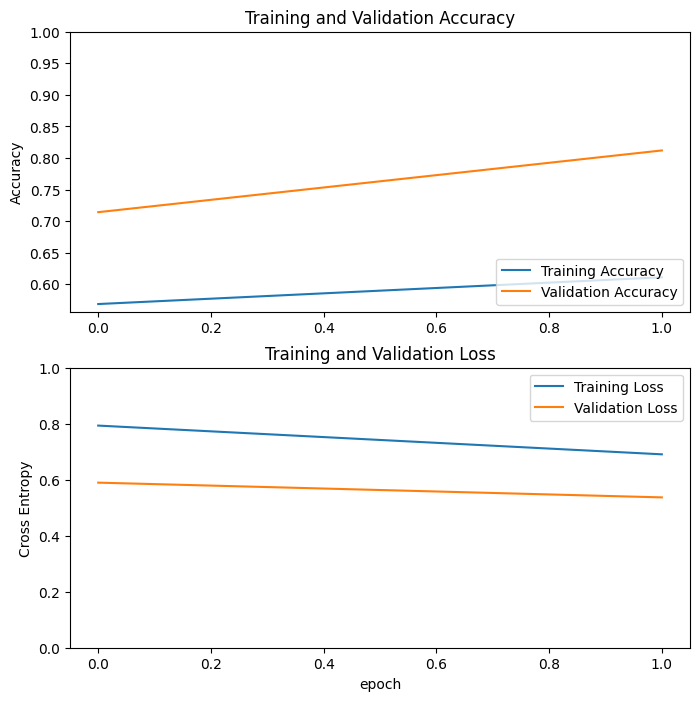

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8750 - loss: 0.4806
Test accuracy : 0.875


Predictions:
 [0 0 1 0 1 1 0 0 1 0 0 0 0 1 0 1]
Labels:
 [0 0 1 0 1 1 1 0 1 0 0 0 0 1 1 1]


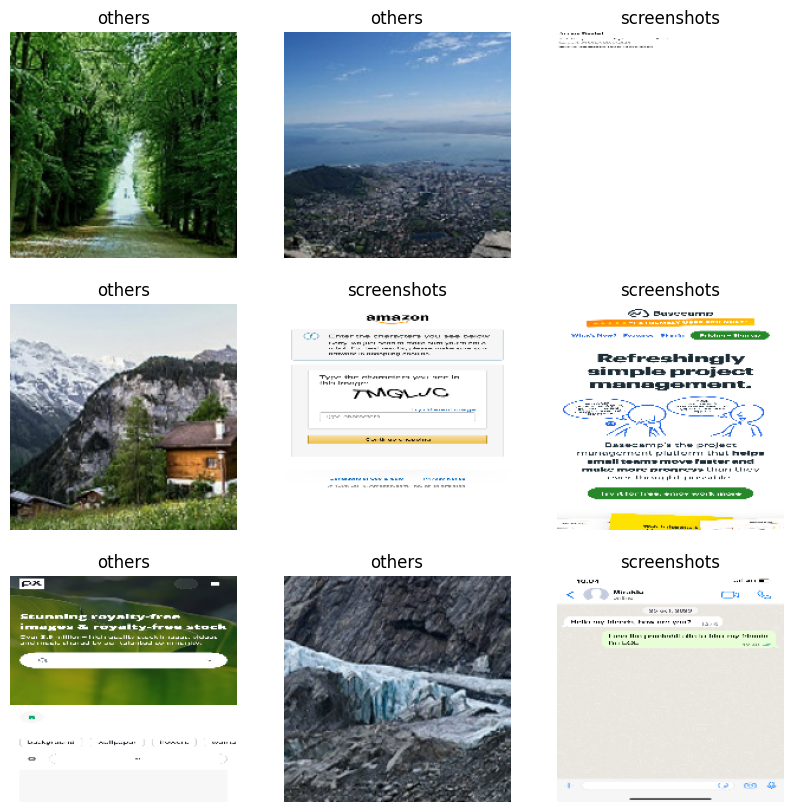

In [ ]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()

predictions = model.predict_on_batch(image_batch)

predicted_class_index = (predictions > 0.5).astype(int)

print('Predictions:\n', predicted_class_index.flatten())
print('Labels:\n', label_batch.flatten())

batch_size = image_batch.shape[0]
num_to_plot = min(batch_size, 9)
plt.figure(figsize=(10, 10))
for i in range(num_to_plot):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predicted_class_index[i][0]])
    plt.axis("off")
plt.show()

# Try it out!

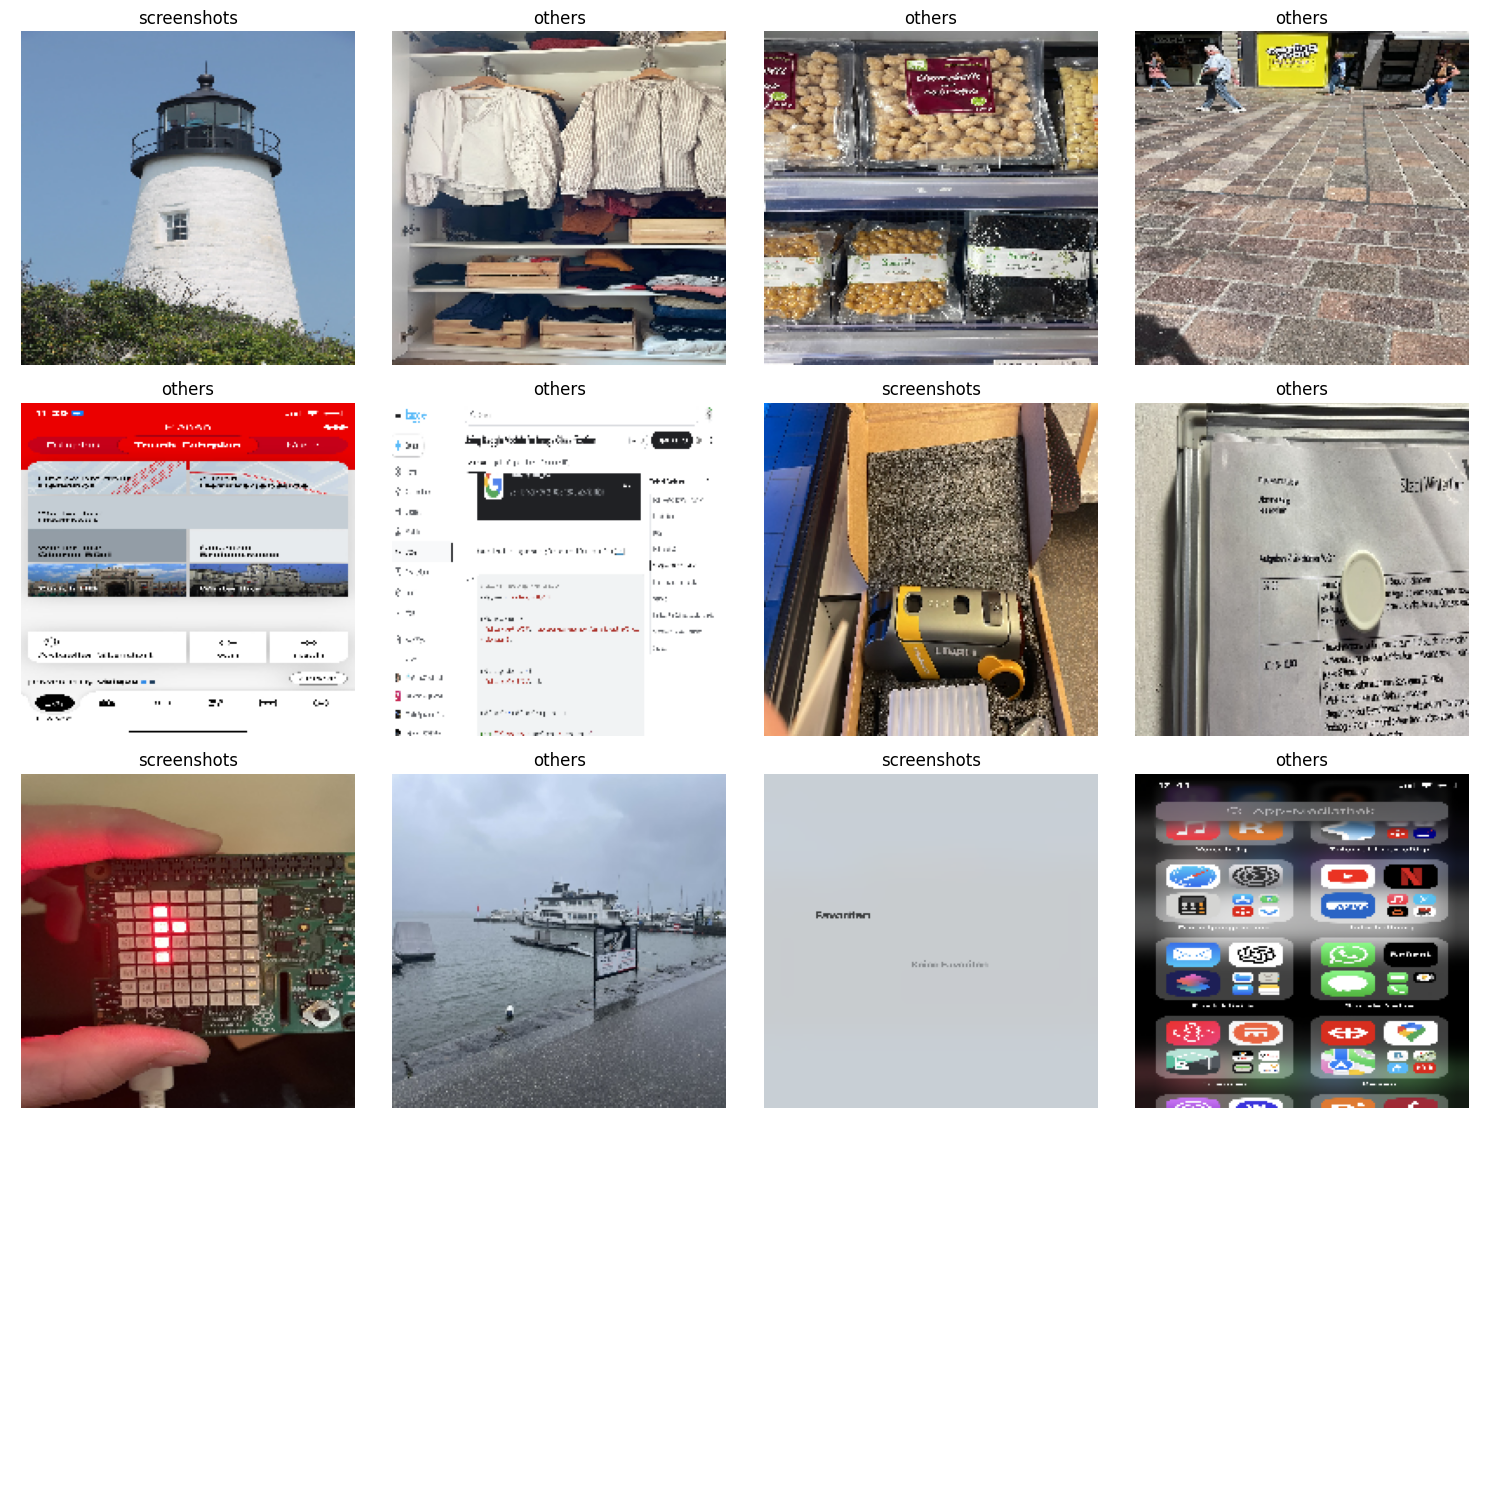

In [ ]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt

directory = "examples/"

images = []
predictions = []

for filename in os.listdir(directory):
    img_path = os.path.join(directory, filename)
    if filename.lower().endswith((".png", ".jpg", ".jpeg")):
        img = tf.keras.utils.load_img(img_path, target_size=(192, 192))
        img_array = tf.keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)
        prediction = model.predict_on_batch(img_array)
        predicted_class_index = (prediction > 0.5).astype(int)
        predicted_class = class_names[predicted_class_index[0][0]]
        images.append(img)
        predictions.append(predicted_class)

num_images = len(images)
grid_size = int(num_images**0.5) + 1

fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
axes = axes.flatten()

for i, (img, prediction) in enumerate(zip(images, predictions)):
    axes[i].imshow(img)
    axes[i].set_title(prediction)
    axes[i].axis("off")

for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()
